In [1]:
# Setting the environment variables

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [3]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("log_reg") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [4]:
print('spark.driver.memory =', spark.sparkContext.getConf().get('spark.driver.memory'))


spark.driver.memory = 14G


In [5]:
from pyspark.ml import PipelineModel

from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml.classification import DecisionTreeClassificationModel
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.feature import StringIndexerModel

from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from itertools import chain


In [8]:
transformed_df= spark.read.parquet("features_df.parquet")


In [9]:
transformed_df.show(2)

+-----------+------+--------------+-----------+----------+---------+-------------+--------------+------------------+---------------------+-----------------+---------+------------+------------+--------------+------------+--------------+------------+--------------+------------------+---------------+-------------+--------------------+
|  cat_0_cln| price|category_level|day_of_week| cat_1_cln|brand_cln|session_count|activity_count|product_view_count|second_cat_view_count|        avg_price|hour_bins|is_purchased|cat_0_cln_ix| cat_0_cln_enc|cat_1_cln_ix| cat_1_cln_enc|brand_cln_ix| brand_cln_enc|category_level_enc|day_of_week_enc|hour_bins_enc|            features|
+-----------+------+--------------+-----------+----------+---------+-------------+--------------+------------------+---------------------+-----------------+---------+------------+------------+--------------+------------+--------------+------------+--------------+------------------+---------------+-------------+--------------------

In [10]:
transformed_df.select('features').limit(5).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------+
|(91,[0,13,52,73,76,84,85,86,87,88,89,90],[1.0,1.0,1.0,1.0,1.0,1.0,380.2799987792969,2.0,1.0,1.0,1.0,493.3872257223995])  |
|(91,[0,13,52,73,81,84,85,86,87,88,89,90],[1.0,1.0,1.0,1.0,1.0,1.0,246.52000427246094,5.0,1.0,3.0,3.0,493.3872257223995]) |
|(91,[0,17,58,74,77,84,85,86,87,88,89,90],[1.0,1.0,1.0,1.0,1.0,1.0,389.9200134277344,10.0,1.0,4.0,7.0,493.3872257223995]) |
|(91,[0,13,53,73,76,84,85,86,87,88,89,90],[1.0,1.0,1.0,1.0,1.0,1.0,1671.3399658203125,9.0,1.0,9.0,18.0,493.3872257223995])|
|(91,[0,13,52,73,79,83,85,86,87,88,89,90],[1.0,1.0,1.0,1.0,1.0,1.0,131.63999938964844,3.0,1.0,3.0,3.0,493.3872257223995]) |
+-------

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


In [11]:
pipeline_model = PipelineModel.load('pipeline_model')
pipeline_model.stages

[StringIndexer_39d3d8138bed,
 OneHotEncoder_28ce3beb1af7,
 StringIndexer_a61edbfba1ce,
 OneHotEncoder_30fcbbfd1358,
 StringIndexer_782af24a7fc3,
 OneHotEncoder_6104bade4eba,
 OneHotEncoder_f529db65a95c,
 OneHotEncoder_23e2558e1614,
 OneHotEncoder_8f91ecdb56a2,
 VectorAssembler_79e76ebf349d]

### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [12]:
"StringIndexerModel" in str(type(pipeline_model.stages[0]))

True

In [13]:
#Extracting the feature mapping of the feature column
# This is to show the feature importances in a meaningful way

mapping_list= list(transformed_df.schema['features'].metadata["ml_attr"]["attrs"].values())
# Mapping list will have numeric mappings in index 0 and binary mappings in index 1
#Putting it in a DataFrame
mapping_df = pd.DataFrame(mapping_list[0] + mapping_list[1])
mapping_df.sort_values('idx', inplace=True)
mapping_df.reset_index(drop=True, inplace=True)
mapping_df

,idx,name
0,0,cat_0_cln_enc_electronics
1,1,cat_0_cln_enc_Blank
2,2,cat_0_cln_enc_appliances
3,3,cat_0_cln_enc_computers
4,4,cat_0_cln_enc_construction
...,...,...
86,86,session_count
87,87,activity_count
88,88,product_view_count
89,89,second_cat_view_count


In [14]:
#_, test = transformed_df.randomSplit([0.8, 0.2], seed=12)

<hr>

## Task 4: Model Inference

- Feature Importance
- Model Inference
- Feature exploration

In [15]:
lr_model = LogisticRegressionModel.load('log_reg_model')
print('LR description: ',lr_model)
lr_coeff = lr_model.coefficientMatrix
# lr_coeff will be a Dense Matrix. Since it is one dimensional we can convert it into an array
lr_coeff = lr_coeff.toArray().squeeze()
lr_coeff_df = pd.DataFrame(data=lr_coeff, columns=['LR_coeff'])
print('LR coefficients: ')
lr_coeff_df


LR description:  LogisticRegressionModel: uid = LogisticRegression_aa790391f4b9, numClasses = 2, numFeatures = 91
LR coefficients: 


,LR_coeff
0,-0.039179
1,-0.186300
2,-0.386700
3,-0.115507
4,-0.726590
...,...
86,-0.012276
87,0.024254
88,0.070850
89,-0.003140


In [16]:

#lr_feat_mapping = pd.concat([mapping_df, lr_coeff_df], axis=1)
lr_feat_mapping = mapping_df.join(lr_coeff_df, on='idx', how='left')

lr_feat_mapping.sort_values('LR_coeff', ascending=False)

,idx,name,LR_coeff
36,36,cat_1_cln_enc_bag,8.713278
48,48,cat_1_cln_enc_bathroom,0.704353
53,53,brand_cln_enc_apple,0.604313
57,57,brand_cln_enc_oppo,0.586493
52,52,brand_cln_enc_samsung,0.531580
...,...,...,...
45,45,cat_1_cln_enc_fmcg,-0.921268
47,47,cat_1_cln_enc_tshirt,-0.951248
42,42,cat_1_cln_enc_dolls,-1.016013
10,10,cat_0_cln_enc_medicine,-1.347057


## Decision Tree

In [17]:
tree = DecisionTreeClassificationModel.load('decision_tree_model')
tree

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_b84abb6e14f1) of depth 7 with 113 nodes

In [18]:
tree.featureImportances
tree_feat_imp = tree.featureImportances.toArray().squeeze()
tree_feat_imp_df = pd.DataFrame(data=tree_feat_imp, columns=['Tree Feat Imp'])
print('Decision Tree Feature Importances: ')
tree_feat_imp_df.sort_values('Tree Feat Imp', ascending=False)


Decision Tree Feature Importances: 


,Tree Feat Imp
88,0.482040
86,0.208187
13,0.130264
87,0.083009
89,0.069410
...,...
30,0.000000
29,0.000000
28,0.000000
27,0.000000


In [19]:
#tree_feat_mapping = pd.concat([mapping_df, tree_feat_imp_df], axis=1)

tree_feat_mapping = mapping_df.join(tree_feat_imp_df, on='idx', how='left')

tree_feat_mapping.sort_values('Tree Feat Imp', ascending=False)

,idx,name,Tree Feat Imp
88,88,product_view_count,0.482040
86,86,session_count,0.208187
13,13,cat_1_cln_enc_smartphone,0.130264
87,87,activity_count,0.083009
89,89,second_cat_view_count,0.069410
...,...,...,...
30,30,cat_1_cln_enc_components,0.000000
29,29,cat_1_cln_enc_sewing_machine,0.000000
28,28,cat_1_cln_enc_personal,0.000000
27,27,cat_1_cln_enc_desktop,0.000000


In [26]:
tree.extractParamMap()

{Param(parent='DecisionTreeClassifier_b84abb6e14f1', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='DecisionTreeClassifier_b84abb6e14f1', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='DecisionTreeClassifier_b84abb6e14f1', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256,
 Param(parent='DecisionTreeClassifier_b84abb6e14f1', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0,
 Param(parent='DecisionTreeClassifier_b84abb6e14f1', name='predictionCol', doc='prediction column na

## Random Forest

In [20]:
rf_model = RandomForestClassificationModel.load('random_forest_model')
rf_model.extractParamMap()

{Param(parent='RandomForestClassifier_1c65d13eaa9b', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_1c65d13eaa9b', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_1c65d13eaa9b', name='maxMemoryInMB', doc='Maximum memory in MB allocated to histogram aggregation.'): 256,
 Param(parent='RandomForestClassifier_1c65d13eaa9b', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0,
 Param(parent='RandomForestClassifier_1c65d13eaa9b', name='predictionCol', doc='prediction column na

In [21]:
rf_feat_imp = rf_model.featureImportances.toArray().squeeze()
rf_feat_imp_df = pd.DataFrame(data=rf_feat_imp, columns=['RF Feat Imp'])
print('Random Forest Feature Importances: ')
rf_feat_imp_df.sort_values('RF Feat Imp', ascending=False)


Random Forest Feature Importances: 


,RF Feat Imp
88,0.417191
86,0.213658
0,0.048166
13,0.048022
90,0.042323
...,...
47,0.000000
49,0.000000
50,0.000000
51,0.000000


In [22]:
#rf_feat_mapping = pd.concat([mapping_df, rf_feat_imp_df], axis=1)
rf_feat_mapping = mapping_df.join(rf_feat_imp_df, on='idx', how='left')
rf_feat_mapping.sort_values('RF Feat Imp', ascending=False)

,idx,name,RF Feat Imp
88,88,product_view_count,0.417191
86,86,session_count,0.213658
0,0,cat_0_cln_enc_electronics,0.048166
13,13,cat_1_cln_enc_smartphone,0.048022
90,90,avg_price,0.042323
...,...,...,...
47,47,cat_1_cln_enc_tshirt,0.000000
49,49,cat_1_cln_enc_cultivator,0.000000
50,50,cat_1_cln_enc_tennis,0.000000
51,51,cat_1_cln_enc_sock,0.000000


## Collating all the feature weights

In [23]:
overall_mapping_df = lr_feat_mapping.join(tree_feat_imp_df, on='idx', how='left')
overall_mapping_df = overall_mapping_df.join(rf_feat_imp_df, on='idx', how='left')
overall_mapping_df

,idx,name,LR_coeff,Tree Feat Imp,RF Feat Imp
0,0,cat_0_cln_enc_electronics,-0.039179,0.000000,0.048166
1,1,cat_0_cln_enc_Blank,-0.186300,0.000000,0.023231
2,2,cat_0_cln_enc_appliances,-0.386700,0.000000,0.001648
3,3,cat_0_cln_enc_computers,-0.115507,0.000000,0.002306
4,4,cat_0_cln_enc_construction,-0.726590,0.000000,0.000000
...,...,...,...,...,...
86,86,session_count,-0.012276,0.208187,0.213658
87,87,activity_count,0.024254,0.083009,0.035325
88,88,product_view_count,0.070850,0.482040,0.417191
89,89,second_cat_view_count,-0.003140,0.069410,0.020001


In [24]:
# Creating a dataframe to contain the top 5 features of each of the model

top_feat_df = overall_mapping_df.sort_values('Tree Feat Imp', ascending=False)[:5][['idx', 'Tree Feat Imp']]
top_feat_df = top_feat_df.join(overall_mapping_df.sort_values('RF Feat Imp', ascending=False)[:5][['idx', 'RF Feat Imp']],
                          on = 'idx',
                          how = 'outer',
                        rsuffix='_RF_join'
                               
                         )
top_feat_df = top_feat_df.join(overall_mapping_df.sort_values('LR_coeff', ascending=False)[:5][['idx', 'LR_coeff']],
                          on = 'idx',
                          how = 'outer',
                        rsuffix='_LR_join'
                               
                         )
top_feat_df = top_feat_df.join(overall_mapping_df[['idx', 'name']],
                               on = 'idx',
                               how='left',
                               rsuffix = '_mapping'
                              )
top_feat_df.drop(['idx_LR_join', 'idx_RF_join', 'idx_mapping'],axis=1, inplace=True)
top_feat_df

,idx,Tree Feat Imp,RF Feat Imp,LR_coeff,name
88.0,88,0.482040,0.417191,NaN,product_view_count
86.0,86,0.208187,0.213658,NaN,session_count
13.0,13,0.130264,0.048022,NaN,cat_1_cln_enc_smartphone
87.0,87,0.083009,NaN,NaN,activity_count
89.0,89,0.069410,NaN,NaN,second_cat_view_count
NaN,0,NaN,0.048166,NaN,cat_0_cln_enc_electronics
NaN,90,NaN,0.042323,NaN,avg_price
NaN,36,NaN,NaN,8.713278,cat_1_cln_enc_bag
NaN,48,NaN,NaN,0.704353,cat_1_cln_enc_bathroom
NaN,53,NaN,NaN,0.604313,brand_cln_enc_apple


Text(0.5, 1.0, 'Top 5 influential Features')

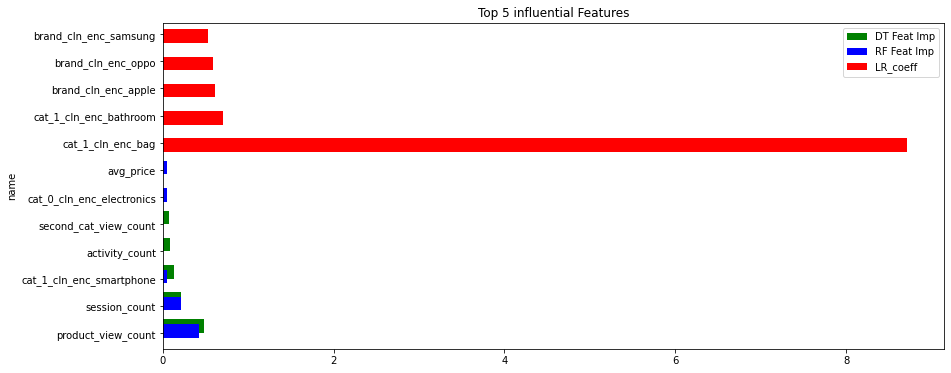

In [25]:
fig, ax = plt.subplots(1,1,figsize=(14,6))
top_feat_df.plot(kind='barh', 
                 y ='Tree Feat Imp',
                 x = 'name',
                 color='g',
                 ax=ax,
                 position=0,
                 label='DT Feat Imp'
                )
top_feat_df.plot(kind='barh', 
                 y ='RF Feat Imp',
                 x = 'name',
                 color='b',
                 ax=ax,
                 position=0.33,
                 label = 'RF Feat Imp'
                )
top_feat_df.plot(kind='barh', 
                 y ='LR_coeff',
                 x = 'name',
                 color='r',
                 position=0.66,
                 ax=ax
                )
plt.title('Top 5 influential Features')